In [55]:
import jax
import jax.numpy as jnp

key = jax.random.key(0)

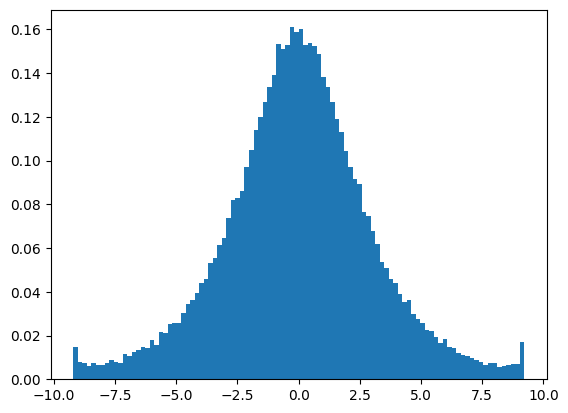

In [71]:
import matplotlib.pyplot as plt

xs = 0.5 + 0.5*jnp.cos(jnp.pi * jax.random.uniform(key, shape=(100000,)))
xs = 0.9998 * xs + 1e-4
xs = -jnp.log(xs / (1 - xs))

plt.hist(xs, bins=100, density=True);

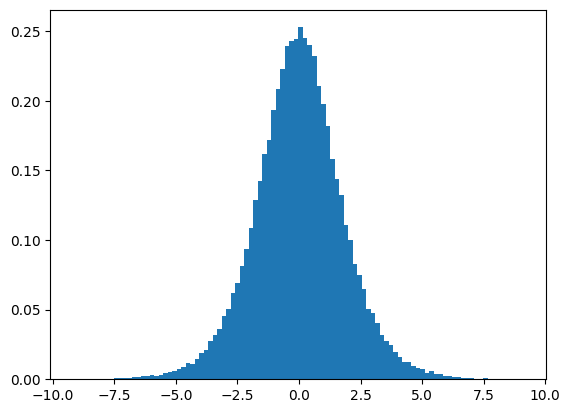

In [72]:
import matplotlib.pyplot as plt

xs = jax.random.uniform(key, shape=(100000,))
xs = 0.9998 * xs + 1e-4
xs = -jnp.log(xs / (1 - xs))

plt.hist(xs, bins=100, density=True);

In [50]:
import jax
import jax.numpy as jnp

def insert_empty_tokens(key, input_ids, empty_token_id: int = -1, max_empty_token_frac: float = 0.2):
    assert 0.0 <= max_empty_token_frac < 1.0

    if max_empty_token_frac == 0.0:
        return input_ids

    batch_size, seq_len = input_ids.shape
    total_len = int(round(seq_len / (1.0 - max_empty_token_frac)))

    frac_key, key = jax.random.split(key)
    empty_token_fracs = jax.random.uniform(frac_key, shape=(batch_size,)) * max_empty_token_frac

    keys = jax.random.split(key, batch_size)

    def per_example(seq, k, empty_frac):
        empty_count = jnp.ceil(seq_len * (empty_frac / (1.0 - empty_frac))).astype(jnp.int32)
        perm = jax.random.permutation(k, seq_len)
        ranks = jnp.full((total_len,), total_len, dtype=jnp.int32).at[perm].set(jnp.arange(seq_len, dtype=jnp.int32))
        empty_mask = ranks < empty_count
        dest = jnp.nonzero(~empty_mask, size=seq_len, fill_value=0)[0]
        out = jnp.full((total_len,), empty_token_id, dtype=seq.dtype).at[dest].set(seq)
        return out

    return jax.vmap(per_example)(input_ids, keys, empty_token_fracs)[:, :seq_len]



In [53]:
_key, key = jax.random.split(key)
x = insert_empty_tokens(_key, jnp.broadcast_to(jnp.arange(16), (4, 16)), empty_token_id=-1)
(x == -1).mean(-1), x

(Array([0.125 , 0.0625, 0.25  , 0.0625], dtype=float32),
 Array([[ 0,  1,  2, -1,  3, -1,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13],
        [ 0,  1,  2,  3,  4, -1,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
        [-1,  0,  1,  2,  3,  4,  5,  6,  7, -1,  8, -1, -1,  9, 10, 11],
        [ 0,  1,  2,  3,  4, -1,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]],      dtype=int32))

<BarContainer object of 32 artists>

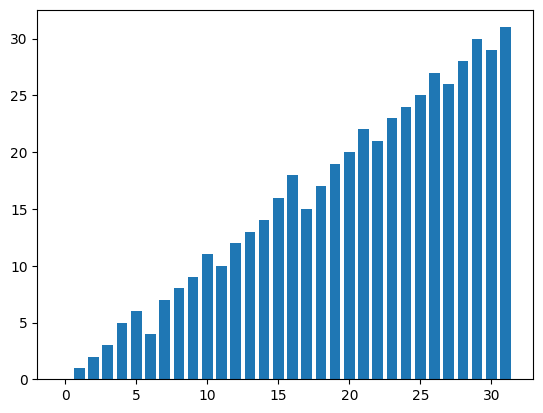

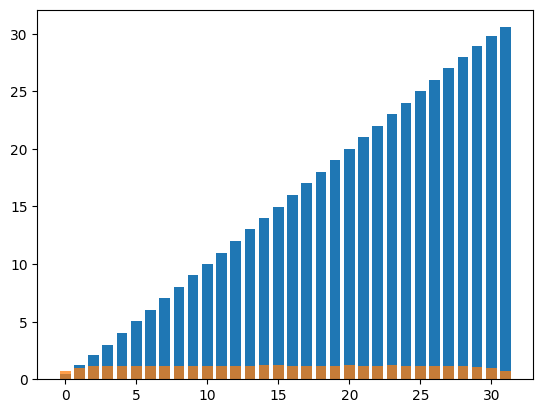

In [275]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

key = jax.random.split(key, 2)[0]
rand = jax.random.normal(key, (1000, 32,))
std = 1.2

x = jnp.arange(32)[None, :]
y = (x + std * rand).argsort(-1)


plt.figure()
plt.bar(x[0], y[0], width=0.75, align="center")

plt.figure()
plt.bar(x[0], y.mean(0), width=0.75, align="center")
plt.bar(x[0], y.std(0), width=0.75, align="center", alpha=0.75)

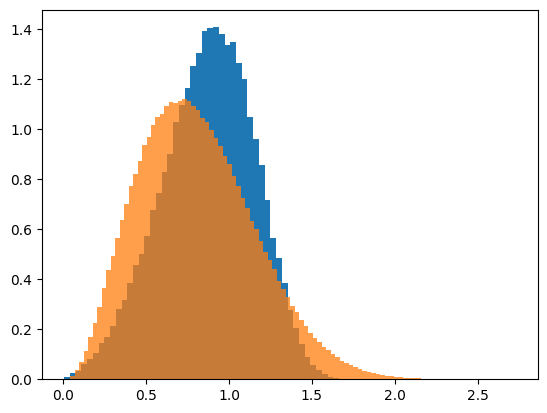

In [245]:
y1 = jnp.log10(4*jax.random.gamma(key, 2.0, (100000,)) + 1)

plt.hist(y1, bins=50, density=True);

y2 = jnp.log10(5*jax.random.lognormal(key, 1.0, (1000000,)) + 1)

plt.hist(y2, bins=100, density=True, alpha=0.75);

# plt.yscale("log")
# plt.xlim(0, 50)

In [272]:
(y2 < jnp.log10(1.2)).mean()

Array(0.000672, dtype=float32)

In [39]:

import typing as tp
from functools import partial
import warnings

import chex
import jax
import jax.numpy as jnp
from eformer import common_types
from eformer.escale import apply_logical_sharding
from flax import nnx as nn

from easydel.infra.base_module import EasyDeLBaseModule
from easydel.infra.factory import TaskType, register_module
from easydel.infra.modeling_outputs import (
    AttentionLayerOutput,
    BaseModelOutput,
    CausalLMOutput,
    DecoderLayerOutput,
)
from easydel.infra.utils import (
    ACT2FN,
    auto_remat,
    block_wise_ffn,
    get_dot_general_by_bits,
)
from easydel.layers.attention import AttentionModule, FlexibleAttentionModule
from easydel.layers.caching import (
    PagesCache,
    PagesCacheView,
    PagesMetadata,
    TransformerCache,
    TransformerCacheView,
    TransformerMetadata,
)
from easydel.layers.linear import ParallelLinear

from model.gidd_configuration import GiddConfig



class GiddAttention(AttentionModule):
    def __init__(
        self,
        config: GiddConfig,
        dtype: jnp.dtype = jnp.float32,
        param_dtype: jnp.dtype = jnp.float32,
        precision: jax.lax.PrecisionLike = None,
        *,
        rngs: nn.Rngs,
    ):
        super().__init__(config=config)
        self.dtype = dtype
        self.param_dtype = param_dtype
        self.precision = precision
        self.rngs = rngs

        self.hidden_size = config.hidden_size
        head_dim = config.hidden_size // config.num_attention_heads
        self.head_dim = getattr(config, "head_dim", head_dim)
        self.num_attention_heads = self.hidden_size // self.head_dim
        self.is_causal = config.is_causal

        self.use_qk_norm = config.use_qk_norm
        self.qk_norm_eps = config.qk_norm_eps
        if self.use_qk_norm:
            self.qk_scale = nn.Param(
                jnp.full(
                    (1, 1, self.num_attention_heads, 1),
                    2 * jnp.log(config.max_position_embeddings),
                    dtype=self.param_dtype,
                ),
            )
        else:
            self.qk_scale = 1.0

        linear_class = partial(
            ParallelLinear,
            scale=config.weight_scaling,
            dtype=dtype,
            param_dtype=param_dtype,
            use_bias=config.attention_bias,
            kernel_init=jax.nn.initializers.normal(config.init_scale),
            precision=precision,
            **get_dot_general_by_bits(config.bits, config.easy_method),
        )
        self.q_proj = linear_class(
            self.hidden_size,
            self.num_attention_heads * self.head_dim,
            rngs=rngs,
        )
        self.k_proj = linear_class(
            self.hidden_size,
            self.num_attention_heads * self.head_dim,
            rngs=rngs,
        )
        self.v_proj = linear_class(
            self.hidden_size,
            self.num_attention_heads * self.head_dim,
            rngs=rngs,
        )
        self.o_proj = linear_class(
            self.num_attention_heads * self.head_dim,
            self.hidden_size,
            rngs=rngs,
        )

        self.rotary = self.config.get_basic_rope(
            self.dtype,
            self.head_dim,
            self.head_dim,
            True,
        )

        self.attention_performer = FlexibleAttentionModule(
            base_config=self.config,
            softmax_scale=1.0 if self.use_qk_norm else 1.0 / self.head_dim**0.5,
            dropout_prob=0.0,
        )

        
    @jax.named_scope("gidd-flax-attention-concatenate")
    def concatenate(
        self,
        *,
        query: chex.Array,
        key: chex.Array,
        value: chex.Array,
        attention_mask: chex.Array,
        noise_mask: chex.Array,
        # mode: common_types.RUNTIME_MODE_TYPES,  # type:ignore
        cache_view: TransformerCacheView | PagesCacheView | None = None,
        cache_metadata: TransformerMetadata | PagesMetadata | None = None,
    ) -> tp.Tuple[chex.Array, chex.Array, chex.Array, tp.Callable[[], chex.Array]]:
        """
        Adapted from parent class
        """

        assert query.shape[1] == key.shape[1], "Query and Key lengths must match for GIDD attention."
        if attention_mask is not None:
            if attention_mask.dtype != jnp.bool:
                warnings.warn("attention_mask should be a boolean array", stacklevel=1)
                attention_mask = (attention_mask == 1).astype("b1")

        attention_mask = jnp.expand_dims(attention_mask, axis=(-3, -2))
        attention_mask = jnp.repeat(attention_mask, query.shape[1], -2)
        # shape: [Batch, 1, q_len, kv_len]

        if noise_mask is not None:
            if noise_mask.dtype != jnp.bool:
                warnings.warn("noise_mask should be a boolean array", stacklevel=1)
                noise_mask = (noise_mask == 1).astype("b1")
            noise_mask_q = jnp.expand_dims(noise_mask, axis=-1)
            noise_mask_kv = jnp.expand_dims(noise_mask, axis=-2)
            noise_attn_mask = jnp.expand_dims(noise_mask_q >= noise_mask_kv, axis=-3)
            attention_mask = jnp.logical_and(attention_mask, noise_attn_mask)

        def init_attention_bias():
            return jax.lax.select(
                attention_mask > 0,
                jnp.full(attention_mask.shape, 0.0).astype(self.dtype),
                jnp.full(attention_mask.shape, jnp.finfo(self.dtype).min).astype(self.dtype),
            )

        return key, value, attention_mask, init_attention_bias, cache_view
    
    def _norm(self, x: jnp.ndarray) -> jnp.ndarray:
        return x * jax.lax.rsqrt(jnp.square(x).sum(-1, keepdims=True) + self.qk_norm_eps)

    def __call__(
        self,
        hidden_states: chex.Array,
        attention_mask: chex.Array,
        noise_mask: chex.Array,
        position_ids: chex.Array,
        mode: common_types.RUNTIME_MODE_TYPES,  # type:ignore
        cache_view: tp.Optional[TransformerCacheView | PagesCacheView] = None,
        cache_metadata: tp.Optional[TransformerMetadata | PagesMetadata] = None,
        segment_ids: tp.Optional[chex.Array] = None,
        output_attentions: bool = False,
        frequencies: tp.Optional[chex.Array] = None,
    ) -> tp.Tuple[chex.Array, chex.Array]:
        batch_size, sequence_length = hidden_states.shape[:2]
        query_states, key_states, value_states = (
            self.q_proj(hidden_states),
            self.k_proj(hidden_states),
            self.v_proj(hidden_states),
        )
        if self.use_qk_norm:
            query_states = self._norm(query_states)
            key_states = self._norm(key_states)

        qshape = (
            batch_size,
            sequence_length,
            self.config.num_attention_heads,
            self.head_dim,
        )
        kv_shape = (
            batch_size,
            sequence_length,
            self.config.num_attention_heads,
            self.head_dim,
        )
        query_states = query_states.reshape(qshape)
        key_states = key_states.reshape(kv_shape)
        value_states = value_states.reshape(kv_shape)
        # (
        #     query_states,
        #     key_states,
        #     value_states,
        # ) = self.apply_qkv_shardings(query_states, key_states, value_states)

        query_states, key_states = self.rotary(
            positions=position_ids,
            query=query_states,
            key=key_states,
            frequencies=frequencies,
        )

        (
            key_states,
            value_states,
            attention_mask,
            init_attention_bias,
            cache_view,
        ) = self.concatenate(
            query=query_states,
            key=key_states,
            cache_view=cache_view,
            cache_metadata=cache_metadata,
            value=value_states,
            attention_mask=attention_mask,
            noise_mask=noise_mask,
        )

        attentions = self.attention_performer.forward(
            query_states=query_states * self.qk_scale,
            key_states=key_states,
            value_states=value_states,
            mode=mode,
            bias=None,
            # cache_metadata=cache_metadata,
            # cache_view=cache_view,
            # init_bias=init_attention_bias,
            # attention_mask=attention_mask,
            # segment_ids=segment_ids,
            causal=self.is_causal,
        )
        attn_output = self.o_proj(
            # self.shard_attention_prod(
            #     attn_output=self._merge_heads(attentions.attention_outputs)
            # )
            self._merge_heads(attentions.attention_outputs)
        )

        return AttentionLayerOutput(
            attention_output=attn_output,
            attention_weight=attentions.attention_weights if output_attentions else None,
            cache_view=cache_view,
        )

In [55]:
batch_size = 4
seq_len = 512
num_heads = 4
dim = 64 * num_heads

config = GiddConfig(
    hidden_size=dim,
    num_attention_heads=num_heads,
    head_dim=64,
    is_causal=False,
    max_position_embeddings=seq_len,
    use_qk_norm=False,
    qk_norm_eps=1e-5,
    weight_scaling="fan_in",
    init_scale=0.4,
)
attn = GiddAttention(
    config=config,
    dtype=jnp.float32,
    param_dtype=jnp.float32,
    precision=None,
    rngs=nn.Rngs(0),
)

In [56]:
key = jax.random.PRNGKey(0)
hidden_states = jax.random.normal(key, (batch_size, seq_len, dim))

In [57]:
output = attn(
    hidden_states=hidden_states,
    attention_mask=jnp.ones((batch_size, seq_len), dtype=jnp.bool_),
    noise_mask=jnp.zeros((batch_size, seq_len), dtype=jnp.bool_),
    position_ids=jnp.arange(seq_len).reshape(1, -1),
    mode=None,
    cache_view=None,
    cache_metadata=None,
    segment_ids=None,
    output_attentions=True,
    frequencies=None,
)

In [58]:
jax.scipy.special.entr(output.attention_weight).sum(-1)

Array([[[[6.2260084, 6.2255044, 6.2276325, ..., 6.2302547, 6.2216377,
          6.2257767]],

        [[6.2295794, 6.2245398, 6.226898 , ..., 6.2284856, 6.2218323,
          6.224502 ]],

        [[6.2251663, 6.227264 , 6.2254677, ..., 6.231105 , 6.2171817,
          6.223525 ]],

        [[6.227577 , 6.2276793, 6.228648 , ..., 6.2283583, 6.219397 ,
          6.224928 ]]],


       [[[6.229535 , 6.223505 , 6.229323 , ..., 6.229643 , 6.2286406,
          6.2265897]],

        [[6.2232027, 6.2223816, 6.227627 , ..., 6.2261286, 6.227736 ,
          6.224946 ]],

        [[6.2246675, 6.2291193, 6.2265506, ..., 6.2239523, 6.227837 ,
          6.2286987]],

        [[6.2295003, 6.2251844, 6.2288275, ..., 6.228098 , 6.2258267,
          6.2265644]]],


       [[[6.2246876, 6.2264676, 6.22795  , ..., 6.2233667, 6.2238526,
          6.2287526]],

        [[6.2275047, 6.22691  , 6.2282734, ..., 6.2259536, 6.2239075,
          6.2276015]],

        [[6.2281847, 6.2242603, 6.222239 , ..., 6.228063

In [59]:
# compute gradients
def loss(attn, x):
    output = attn(
        hidden_states=x,
        attention_mask=jnp.ones((batch_size, seq_len), dtype=jnp.bool_),
        noise_mask=jnp.zeros((batch_size, seq_len), dtype=jnp.bool_),
        position_ids=jnp.arange(seq_len).reshape(1, -1),
        mode=None,
        cache_view=None,
        cache_metadata=None,
        segment_ids=None,
        output_attentions=True,
        frequencies=None,
    )
    return output.attention_output.sum()

grad_fn = nn.value_and_grad(loss, has_aux=False)
_, grads = grad_fn(attn, hidden_states)

In [61]:
jax.tree.map(lambda g: g.std(), grads)

State({
  'k_proj': {
    'kernel': VariableState( # 1 (4 B)
      type=Param,
      value=Array(0.01140347, dtype=float32)
    )
  },
  'o_proj': {
    'kernel': VariableState( # 1 (4 B)
      type=Param,
      value=Array(1.0769311, dtype=float32)
    )
  },
  'q_proj': {
    'kernel': VariableState( # 1 (4 B)
      type=Param,
      value=Array(0.01112738, dtype=float32)
    )
  },
  'v_proj': {
    'kernel': VariableState( # 1 (4 B)
      type=Param,
      value=Array(1.0743899, dtype=float32)
    )
  }
})

In [51]:
import matplotlib.pyplot as plt
import flax.nnx as nn
import jax
import jax.numpy as jnp

jax.config.update('jax_enable_x64', True)
jax.config.update('jax_platform_name', 'cpu')

from gidd_easydel.diffusion_trainer.loss import GiddLoss
from gidd_easydel.diffusion_trainer.schedule import create_mixing_schedule

dtype = jnp.float32

batch_size = 4
seq_len = 512
vocab_size = 1000
mask_token_id = 0
min_log_snr = -9.0
max_log_snr = 9.0

mixing_schedule = create_mixing_schedule(
    rate="linear",
    vocab_size=vocab_size,
    mask_token_id=mask_token_id,
    min_log_snr=min_log_snr,
    max_log_snr=max_log_snr,
    hybrid_shift=-1000.0,
    dtype=jnp.bfloat16,
)

loss_fn = GiddLoss(
    mixing_schedule=mixing_schedule,
    vocab_size=vocab_size,
    mask_token_id=mask_token_id,
)


key = jax.random.PRNGKey(0)
logits = 20.0 * jax.random.normal(key, (batch_size, seq_len, vocab_size)).astype(jnp.bfloat16)
logits = logits.at[..., mask_token_id].set(-1e6)  # Mask
x_hat = nn.softmax(logits.astype("f4"), axis=-1).astype(logits.dtype)
log_snr = jnp.linspace(min_log_snr, max_log_snr, batch_size * seq_len).reshape(batch_size, seq_len)

labels = jnp.ones((batch_size, seq_len), dtype=jnp.int32)
input_ids = jnp.ones((batch_size, seq_len), dtype=jnp.int32) * 0

logits_partition_spec: PartitionSpec(('fsdp', 'dp'), 'sp', None)
tokens_partition_spec: PartitionSpec(('fsdp', 'dp'), 'sp')


In [ ]:
import flax.nnx as nn
import optax
import chex

def get_loss_weights(log_snr: chex.Array, input_ids: chex.Array, labels: chex.Array) -> chex.Array:
    pi_at_z = mixing_schedule.pi_lambda_at_ids(log_snr, input_ids)
    pi_prime_at_z = mixing_schedule.pi_lambda_prime_at_ids(log_snr, input_ids)
    # pi_at_z = jnp.take_along_axis(pi, input_ids[..., None], axis=-1).squeeze(-1).astype(jnp.float32)  # gather
    # pi_prime_at_z = jnp.take_along_axis(pi_prime, input_ids[..., None], axis=-1).squeeze(-1).astype(jnp.float32)  # gather

    snr = jnp.exp(log_snr)
    delta_zx = (input_ids == labels).astype(log_snr.dtype)
    loss_weights = (pi_at_z - pi_prime_at_z) / (pi_at_z + snr*delta_zx).clip(1e-8)
    return loss_weights.astype(log_snr.dtype)

def get_elbo_weights(
    log_snr: chex.Array,
    input_ids: chex.Array,
    labels: chex.Array,
    return_aux: bool = False,
) -> chex.Array | tuple[chex.Array, dict[str, chex.Array]]:
    """
    Computes the ELBO weights for the given log_snr.
    
    Args:
        log_snr (chex.Array): log signal-to-noise ratio.
        input_ids (chex.Array): noised token IDs.
        labels (chex.Array): target token IDs.
        return_aux (bool): If True, also returns `loss_weights` and `p_log_snr`.
    
    Returns:
        chex.Array or tuple: The ELBO weights, optionally with auxiliary information.
    """
    log_snr = log_snr.astype(jnp.float32)
    loss_weights = get_loss_weights(log_snr, input_ids, labels)
    p_log_snr = mixing_schedule.p_log_snr(log_snr)
    elbo_weights = (loss_weights / p_log_snr.clip(1e-12))
    if return_aux:
        return elbo_weights, {
            "p_log_snr": p_log_snr,
            "loss_weights": loss_weights,
        }
    return elbo_weights

def loss_fn(
    logits: chex.Array,
    input_ids: chex.Array,
    labels: chex.Array,
    log_snr: chex.Array,
    return_aux: bool = False,
    beta_is_div: float = 1.0,
) -> tuple[chex.Array, chex.Array]:
    # log_snr = log_snr.astype(logits.dtype)
    dtype = logits.dtype
    elbo_weights, aux = get_elbo_weights(log_snr, input_ids, labels, return_aux=True)
    loss_weights = aux["loss_weights"].clip(0, 1e3)
    
    logits = logits.at[..., mask_token_id].set(-1e6)  # Mask out the logits for the mask token.
    x_hat = nn.softmax(logits.astype("f4"), axis=-1)

    p_t = mixing_schedule.marginal_probs(log_snr, x_hat).astype(dtype)
    log_p_t = mixing_schedule.marginal_log_probs(log_snr, x_hat).astype(dtype)
    log_q_t = mixing_schedule.marginal_log_probs_from_ids(log_snr, labels, dtype=dtype)

    log_p_zt = jnp.take_along_axis(log_p_t, input_ids[..., None], axis=-1).squeeze(-1).astype(jnp.float32)
    log_q_zt = jnp.take_along_axis(log_q_t, input_ids[..., None], axis=-1).squeeze(-1).astype(jnp.float32)
    ratio = jnp.exp(log_q_zt) / (jnp.exp(log_p_zt) + 1e-12)
    log_ratio = log_q_zt - log_p_zt
    is_div = ratio - log_ratio - 1

    kl_div = optax.losses.kl_divergence_with_log_targets(log_p_t, log_q_t, axis=-1).astype(jnp.float32)

    # loss = elbo_weights * (kl_div + self.beta_is_div * is_div)
    kl_div = (jnp.exp(log_q_t) * (log_q_t - log_p_t)).sum(-1).astype(jnp.float32)
    loss = loss_weights * kl_div + beta_is_div * loss_weights * is_div

    # jax.debug.print("Loss: {loss}, Max loss: {max_loss}", loss=loss.mean(), max_loss=loss.max())
    # max_loss_idx = loss.argmax()
    # jax.debug.print(
    #     "log_snr, kl_div, is_div @ max loss: {log_snr_max}, {kl_div_max}, {is_div_max} (max loss[{max_loss_idx}]={max_loss})",
    #     log_snr_max=log_snr.reshape(-1)[max_loss_idx],
    #     kl_div_max=kl_div.reshape(-1)[max_loss_idx],
    #     is_div_max=is_div.reshape(-1)[max_loss_idx],
    #     max_loss=loss.reshape(-1)[max_loss_idx],
    #     max_loss_idx=max_loss_idx,
    # )
    

    # jax.lax.cond(loss.max() > 1e4, jax.debug.breakpoint, lambda: None)
    # jax.lax.cond(loss.max() > 100, jax.debug.breakpoint, lambda: None)

    if return_aux:
        elbo = elbo_weights.clip(0, 1e6) * (kl_div + is_div)
        return loss, {
            "elbo": elbo,
            "kl_div": kl_div,
            "is_div": is_div,
            "kl_loss": loss_weights * kl_div,
            "is_loss": loss_weights * is_div,
            "loss_weights": loss_weights,
            "elbo_weights": elbo_weights,
            "log_p_t": log_p_t,
            "log_q_t": log_q_t,
            "p_t": p_t,
        }
    return loss

In [53]:
loss_64, metrics_64 = loss_fn(
    logits.astype(jnp.float64),
    input_ids,
    labels,
    log_snr.astype(jnp.float64),
    return_aux=True,
)

loss_32, metrics_32 = loss_fn(
    logits.astype(jnp.float32),
    input_ids,
    labels,
    log_snr.astype(jnp.float32),
    return_aux=True,
)

loss_16, metrics_16 = loss_fn(
    logits.astype(jnp.bfloat16),
    input_ids,
    labels,
    log_snr.astype(jnp.float32),
    return_aux=True,
)

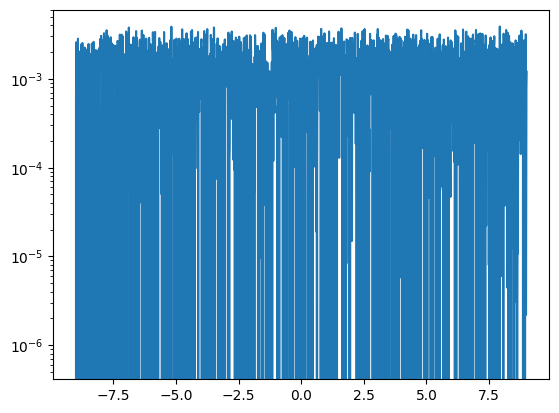

In [54]:
plt.plot(log_snr.reshape(-1), jnp.abs((metrics_64["log_p_t"] - metrics_16["log_p_t"]) / metrics_64["log_p_t"])[..., 1].reshape(-1))
# plt.plot(log_snr.reshape(-1), jnp.exp(metrics_16["log_p_t"])[..., 1].reshape(-1))
plt.yscale("log")

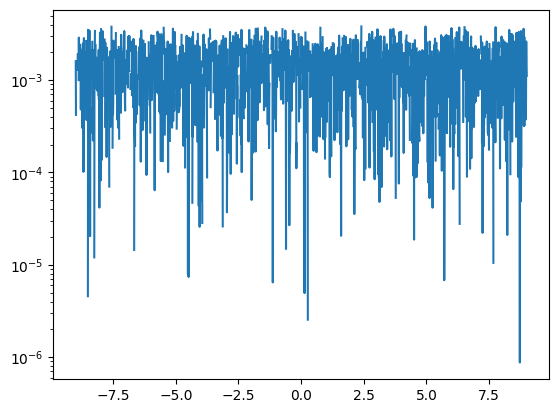

In [55]:
plt.plot(log_snr.reshape(-1), jnp.abs((metrics_64["p_t"] - metrics_16["p_t"]) / metrics_64["p_t"])[..., 1].reshape(-1))
plt.yscale("log")

In [56]:
# rel_err = jnp.abs((metrics_64["p_t"] - metrics_16["p_t"]) / metrics_64["p_t"])[..., 1].reshape(-1)
# mask = rel_err > 0.1
# plt.scatter(log_snr.reshape(-1)[mask], metrics_64["p_t"][..., 1].reshape(-1)[mask])
# plt.scatter(log_snr.reshape(-1)[mask], metrics_16["p_t"][..., 1].reshape(-1)[mask])
# plt.yscale("log")

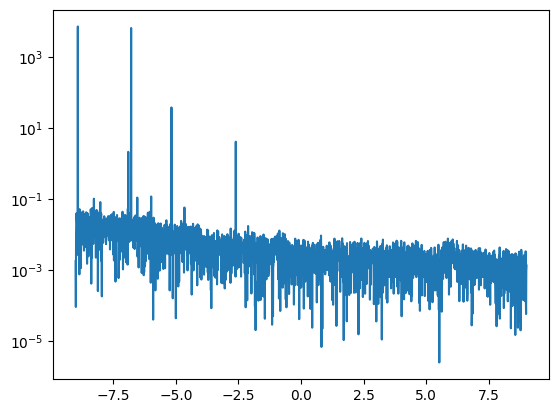

In [58]:
plt.plot(log_snr.reshape(-1), jnp.abs((metrics_64["kl_loss"] - metrics_16["kl_loss"]) / metrics_64["kl_loss"]).reshape(-1))
# plt.plot(log_snr.reshape(-1), metrics_16["kl_loss"].reshape(-1))
plt.yscale("log")

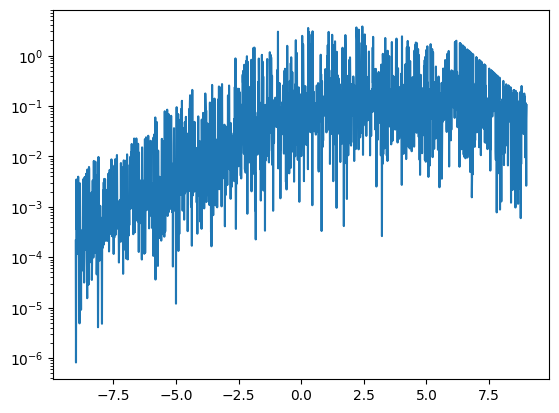

In [59]:
plt.plot(log_snr.reshape(-1), jnp.abs((metrics_64["kl_loss"] - metrics_16["kl_loss"])).reshape(-1))
# plt.plot(log_snr.reshape(-1), metrics_16["kl_loss"].reshape(-1))
plt.yscale("log")

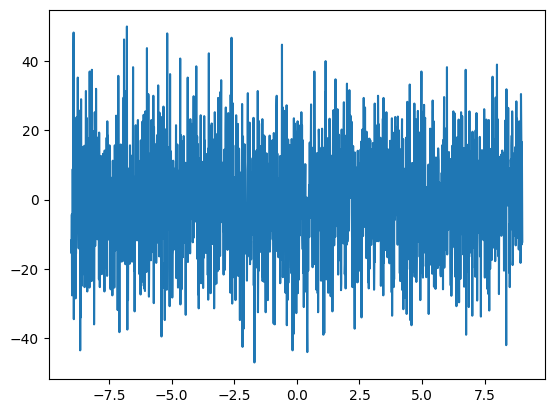

In [124]:
plt.plot(log_snr.reshape(-1), logits[..., 1].reshape(-1))

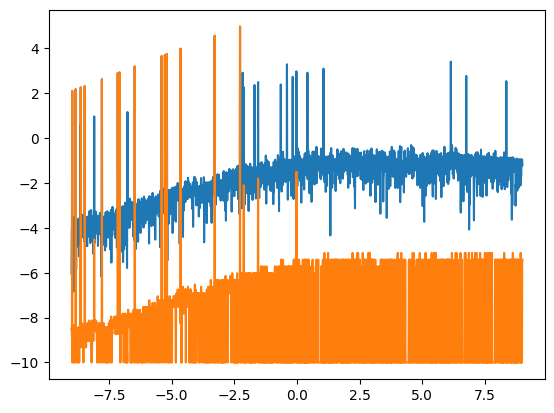

In [ ]:

plt.plot(log_snr.reshape(-1), jnp.log10(jnp.abs(loss_16 - loss_64).clip(1e-10)).reshape(-1))
plt.plot(log_snr.reshape(-1), jnp.log10(jnp.abs(loss_32 - loss_64).clip(1e-10)).reshape(-1))

In [91]:
jnp.isnan(loss_16).any(), loss_16

(Array(False, dtype=bool),
 Array([[1.2300000e+02, 9.0332031e-03, 8.7890625e-03, ..., 5.1171875e-01,
         3.0273438e-01, 7.8906250e-01],
        [6.6015625e-01, 7.2265625e-01, 5.2343750e-01, ..., 4.9356800e+05,
         3.2750000e+01, 3.8250000e+01],
        [3.1875000e+01, 2.9875000e+01, 2.7500000e+01, ..., 5.2750000e+01,
         6.9000000e+01, 6.4500000e+01],
        [2.1250000e+01, 5.0750000e+01, 9.8713600e+05, ..., 4.6250000e+01,
         6.1750000e+01, 7.8500000e+01]], dtype=float32))

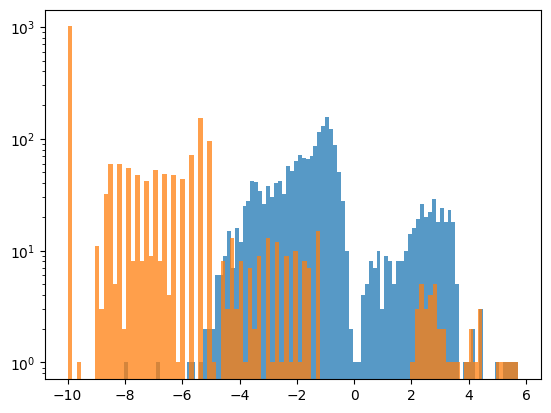

In [82]:
import matplotlib.pyplot as plt

plt.hist(jnp.log10(jnp.abs(loss_16 - loss_64).clip(1e-10)).reshape(-1), bins=100, alpha=0.75);
plt.hist(jnp.log10(jnp.abs(loss_32 - loss_64).clip(1e-10)).reshape(-1), bins=100, alpha=0.75);
plt.yscale('log')

Text(0, 0.5, 'Loss relative error (vs. fp64)')

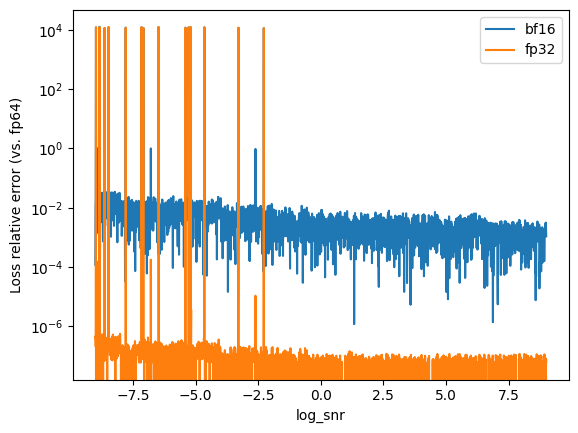

In [116]:

plt.plot(log_snr.reshape(-1), (jnp.abs(loss_16 - loss_64) / loss_64).reshape(-1), label="bf16")
plt.plot(log_snr.reshape(-1), (jnp.abs(loss_32 - loss_64) / loss_64).reshape(-1), label="fp32")
plt.legend()
plt.yscale('log')
plt.xlabel('log_snr')
plt.ylabel('Loss relative error (vs. fp64)')

Text(0, 0.5, 'Loss error (vs. fp64)')

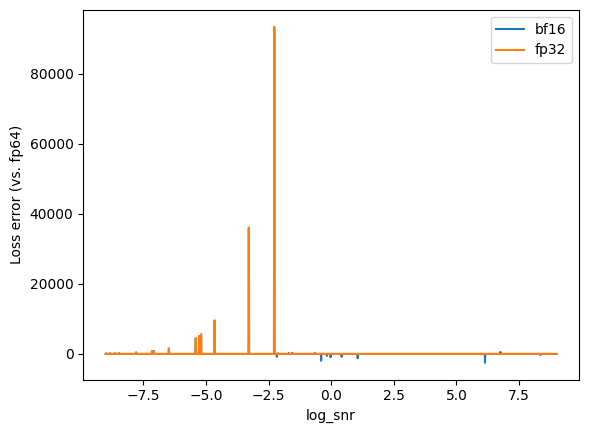

In [143]:

plt.plot(log_snr.reshape(-1), ((loss_16 - loss_64)).reshape(-1), label="bf16")
plt.plot(log_snr.reshape(-1), ((loss_32 - loss_64)).reshape(-1), label="fp32")
plt.legend()
# plt.yscale('log')
plt.xlabel('log_snr')
plt.ylabel('Loss error (vs. fp64)')

Text(0, 0.5, 'Loss')

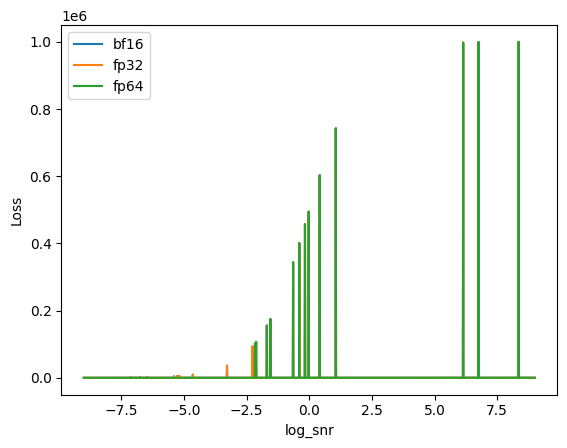

In [144]:

plt.plot(log_snr.reshape(-1), ((loss_16)).reshape(-1), label="bf16")
plt.plot(log_snr.reshape(-1), ((loss_32)).reshape(-1), label="fp32")
plt.plot(log_snr.reshape(-1), ((loss_64)).reshape(-1), label="fp64")
plt.legend()
# plt.yscale('log')
plt.xlabel('log_snr')
plt.ylabel('Loss')

Text(0, 0.5, 'Loss')

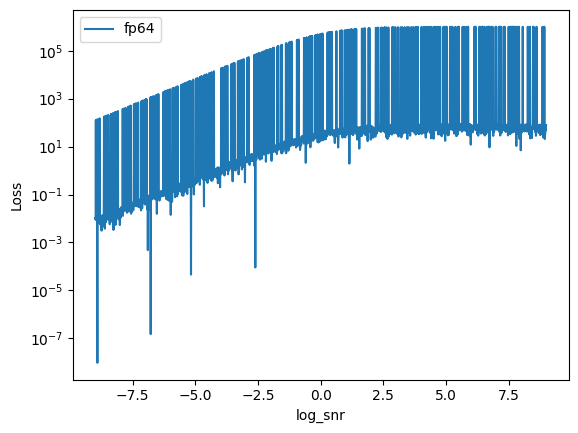

In [86]:

plt.plot(log_snr.reshape(-1), (metrics["kl_loss"]).reshape(-1), label="fp64")
plt.legend()
plt.yscale('log')
plt.xlabel('log_snr')
plt.ylabel('Loss')

In [49]:
def safe_log(x: chex.Array, neg_infty: float = -1e6) -> chex.Array:
    return jnp.where(
        x > 0,
        jnp.log(x.clip(jnp.finfo(x.dtype).tiny)),
        neg_infty,
    )

# def fn(log_snr, logits, input_ids, labels, dtype):
#     alpha = mixing_schedule.alpha_from_log_snr(log_snr)
#     probs_at_z = (1 - alpha).astype(dtype) * jnp.take_along_axis(mixing_schedule.pi_lambda_from_ids(log_snr, labels), labels[..., None], axis=-1).squeeze(-1)
#     probs_at_z = probs_at_z + alpha.astype(dtype)
#     # return safe_log(probs_at_z).astype(dtype)
#     # return jnp.log(probs_at_z).astype(dtype)
#     return probs_at_z.astype(dtype)

def fn(log_snr, logits, input_ids, labels, dtype):
    log_q_t = mixing_schedule.marginal_log_probs_from_ids(log_snr, labels, dtype=dtype)
    log_q_zt = jnp.take_along_axis(log_q_t, input_ids[..., None], axis=-1).squeeze(-1)
    return log_q_zt.astype(dtype)

# def fn(log_snr, logits, input_ids, labels, dtype):
#     elbo_weights, aux = mixing_schedule.get_elbo_weights(log_snr, input_ids, labels, return_aux=True)
#     loss_weights = aux["loss_weights"].clip(0, 1e3)
#     log_p_zt = jnp.take_along_axis(mixing_schedule.marginal_log_probs(log_snr, x_hat), input_ids[..., None], axis=-1).squeeze(-1)
#     log_q_zt = jnp.take_along_axis(mixing_schedule.marginal_log_probs_from_ids(log_snr, labels, dtype=dtype), input_ids[..., None], axis=-1).squeeze(-1)
#     log_ratio = log_q_zt - log_p_zt
#     # return log_q_zt - log_p_zt
#     # return log_p_zt
#     # return jnp.exp(log_ratio.astype(jnp.float64))
#     # return jnp.exp(log_q_zt) / jnp.exp(log_p_zt)
#     is_div = jnp.exp(log_ratio) - log_ratio - 1
#     return (loss_weights * is_div).astype(dtype)


# def fn(log_snr, logits, input_ids, labels, dtype):
#     elbo_weights, aux = mixing_schedule.get_elbo_weights(log_snr, input_ids, labels, return_aux=True)
#     loss_weights = aux["loss_weights"].clip(0, 1e3)

#     logits = logits.at[..., mask_token_id].set(-1e6)  # Mask out the logits for the mask token.
#     x_hat = nn.softmax(logits.astype("f4"), axis=-1).astype(dtype)

#     log_p_t = mixing_schedule.marginal_log_probs(log_snr, x_hat)
#     log_q_t = mixing_schedule.marginal_log_probs_from_ids(log_snr, labels, dtype=dtype)

#     log_p_zt = jnp.take_along_axis(log_p_t, input_ids[..., None], axis=-1).squeeze(-1)
#     log_q_zt = jnp.take_along_axis(log_q_t, input_ids[..., None], axis=-1).squeeze(-1)
#     log_ratio = log_q_zt - log_p_zt
#     is_div = jnp.exp(log_ratio) - log_ratio - 1

#     kl_div = optax.losses.kl_divergence_with_log_targets(log_p_t, log_q_t, axis=-1)

#     return (loss_weights * kl_div + loss_weights * is_div).astype(dtype)


y_64 = fn(log_snr.astype(jnp.float64), logits.astype(jnp.float64), input_ids, labels, dtype=jnp.float64)
y_32 = fn(log_snr.astype(jnp.float32), logits.astype(jnp.float32), input_ids, labels, dtype=jnp.float32)
y_16 = fn(log_snr.astype(jnp.float32), logits.astype(jnp.bfloat16), input_ids, labels, dtype=jnp.bfloat16)

# y_64 = jnp.take_along_axis(mixing_schedule.marginal_log_probs_from_ids(log_snr.astype(jnp.float64), labels, dtype=jnp.float64), input_ids[..., None], axis=-1).squeeze(-1)
# y_32 = jnp.take_along_axis(mixing_schedule.marginal_log_probs_from_ids(log_snr.astype(jnp.float32), labels, dtype=jnp.float32), input_ids[..., None], axis=-1).squeeze(-1)
# y_16 = jnp.take_along_axis(mixing_schedule.marginal_log_probs_from_ids(log_snr.astype(jnp.float32), labels, dtype=jnp.bfloat16), input_ids[..., None], axis=-1).squeeze(-1).astype(jnp.bfloat16)

# y_64 = jnp.take_along_axis(mixing_schedule.marginal_probs_from_ids(log_snr.astype(jnp.float64), labels, dtype=jnp.float64), input_ids[..., None], axis=-1).squeeze(-1)
# y_32 = jnp.take_along_axis(mixing_schedule.marginal_probs_from_ids(log_snr.astype(jnp.float32), labels, dtype=jnp.float32), input_ids[..., None], axis=-1).squeeze(-1)
# y_16 = jnp.take_along_axis(mixing_schedule.marginal_probs_from_ids(log_snr.astype(jnp.float32), labels, dtype=jnp.bfloat16), input_ids[..., None], axis=-1).squeeze(-1).astype(jnp.bfloat16)

# y_64 = (1 - mixing_schedule.alpha_from_log_snr(log_snr.astype(jnp.float64)))
# y_32 = (1 - mixing_schedule.alpha_from_log_snr(log_snr.astype(jnp.float32)))
# y_16 = (1 - mixing_schedule.alpha_from_log_snr(log_snr.astype(jnp.float32))).astype(jnp.bfloat16)

# y_64 = nn.sigmoid(log_snr.astype(jnp.float64))
# y_32 = nn.sigmoid(log_snr.astype(jnp.float32))
# y_16 = nn.sigmoid(log_snr.astype(jnp.bfloat16).astype(jnp.float64))

In [50]:
y_64.min(), y_64.max()

(Array(-15.9117369, dtype=float64), Array(-8.29193735, dtype=float64))

In [51]:
y_64.reshape(-1)[-1]

Array(-15.90853319, dtype=float64)

In [3]:
plt.plot(log_snr.reshape(-1), (jnp.abs(y_16 - y_64) / jnp.abs(y_64)).reshape(-1), label="bf16")
plt.plot(log_snr.reshape(-1), (jnp.abs(y_32 - y_64) / jnp.abs(y_64)).reshape(-1), label="fp32")
plt.legend()
plt.yscale('log')
plt.xlabel('log_snr')
plt.ylabel('Relative error (vs. fp64)')

NameError: name 'plt' is not defined

Text(0, 0.5, 'Error (vs. fp64)')

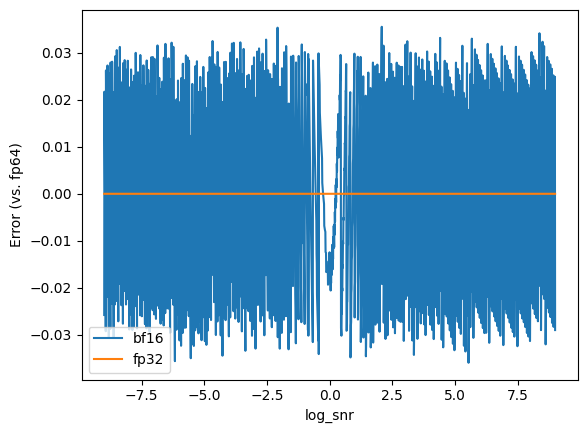

In [53]:
plt.plot(log_snr.reshape(-1), (y_16 - y_64).reshape(-1), label="bf16")
plt.plot(log_snr.reshape(-1), (y_32 - y_64).reshape(-1), label="fp32")
plt.legend()
# plt.yscale('log')
plt.xlabel('log_snr')
plt.ylabel('Error (vs. fp64)')

Text(0, 0.5, '')

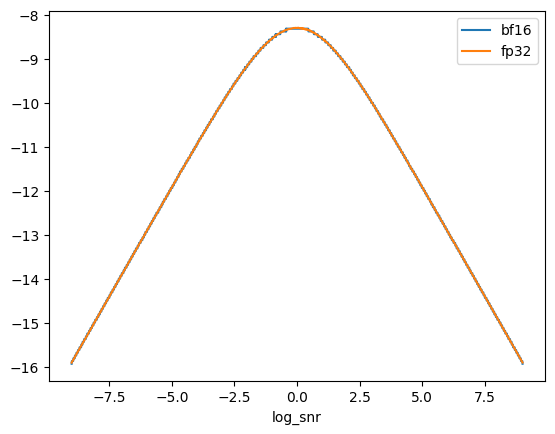

In [54]:
plt.plot(log_snr.reshape(-1), (y_16).reshape(-1), label="bf16")
plt.plot(log_snr.reshape(-1), (y_32).reshape(-1), label="fp32")
plt.legend()
# plt.yscale('log')
plt.xlabel('log_snr')
plt.ylabel('')

Text(0, 0.5, 'Absolute error (vs. fp64)')

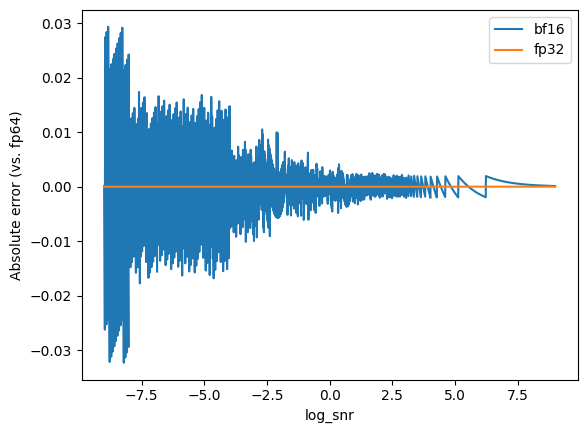

In [46]:
y = 1 / (1 + jnp.exp(-log_snr.astype(jnp.float64)))

# plt.plot(log_snr.reshape(-1), ((jnp.log1p(y.astype(jnp.bfloat16) - 1) - jnp.log(y))).reshape(-1), label="bf16")
# plt.plot(log_snr.reshape(-1), ((jnp.log1p(y.astype(jnp.float32) - 1) - jnp.log(y))).reshape(-1), label="fp32")
plt.plot(log_snr.reshape(-1), ((jnp.log(y.astype(jnp.bfloat16)) - jnp.log(y))).reshape(-1), label="bf16")
plt.plot(log_snr.reshape(-1), ((jnp.log(y.astype(jnp.float32)) - jnp.log(y))).reshape(-1), label="fp32")
plt.legend()
# plt.yscale('log')
plt.xlabel('log_snr')
plt.ylabel('Absolute error (vs. fp64)')

Text(0, 0.5, 'Relative error (vs. fp64)')

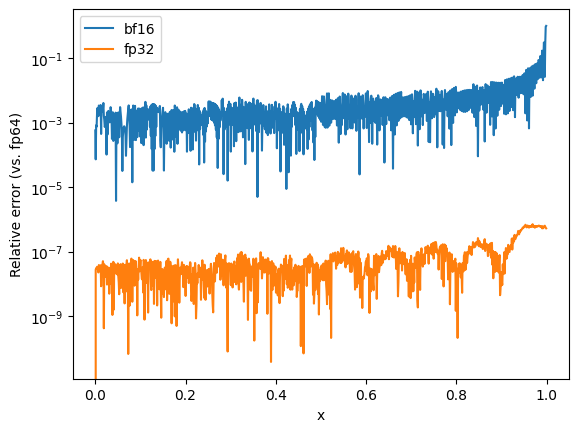

In [64]:

x = jnp.linspace(0, 1, 1000)
y_64 = safe_log(x.astype(jnp.float64))
y_32 = safe_log(x.astype(jnp.float32))
y_16 = safe_log(x.astype(jnp.bfloat16))

plt.plot(x.reshape(-1), (jnp.abs(y_16 - y_64) / jnp.abs(y_64)).reshape(-1), label="bf16")
plt.plot(x.reshape(-1), (jnp.abs(y_32 - y_64) / jnp.abs(y_64)).reshape(-1), label="fp32")
plt.legend()
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('x')
plt.ylabel('Relative error (vs. fp64)')

Text(0, 0.5, 'Relative error (vs. fp64)')

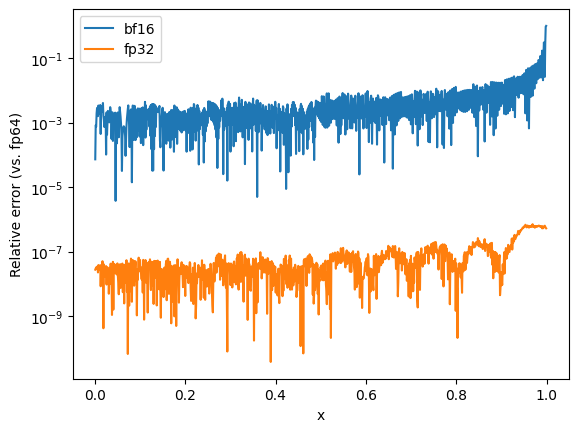

In [65]:

x = jnp.linspace(0, 1, 1000)
y_64 = jnp.log(x.astype(jnp.float64))
y_32 = jnp.log(x.astype(jnp.float32))
y_16 = jnp.log(x.astype(jnp.bfloat16))

plt.plot(x.reshape(-1), (jnp.abs(y_16 - y_64) / jnp.abs(y_64)).reshape(-1), label="bf16")
plt.plot(x.reshape(-1), (jnp.abs(y_32 - y_64) / jnp.abs(y_64)).reshape(-1), label="fp32")
plt.legend()
plt.yscale('log')
# plt.xscale('log')
plt.xlabel('x')
plt.ylabel('Relative error (vs. fp64)')

In [49]:
import jax
import jax.numpy as jnp

In [50]:
key = jax.random.PRNGKey(0)


log_snr = schedule.sample_log_snr(key, (100000,))

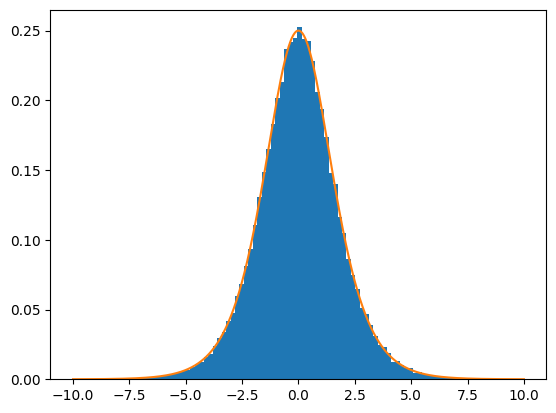

In [54]:
plt.hist(log_snr, bins=100, density=True);
x = jnp.linspace(-10, 10, 1000)
s = 1 / (1 + jnp.exp(-x))
plt.plot(x, s*(1-s))

In [40]:
log_snr = jnp.linspace(-10, 10, 50)
labels = jnp.ones((3, 50), dtype=jnp.int32)
input_ids = jnp.zeros((3, 50), dtype=jnp.int32)
input_ids = input_ids.at[1].set(1)  # Set the first token to a non-mask token
input_ids = input_ids.at[2].set(2)  # Set the second token to a non-mask token

elbo_weights, aux = schedule.get_elbo_weights(
    log_snr[None, :].repeat(3, axis=0),
    input_ids,
    labels,
    return_aux=True,
)

In [41]:
probs = schedule.marginal_probs_from_ids(log_snr, labels[0])

In [42]:
schedule._distribution._mask_token_id

0

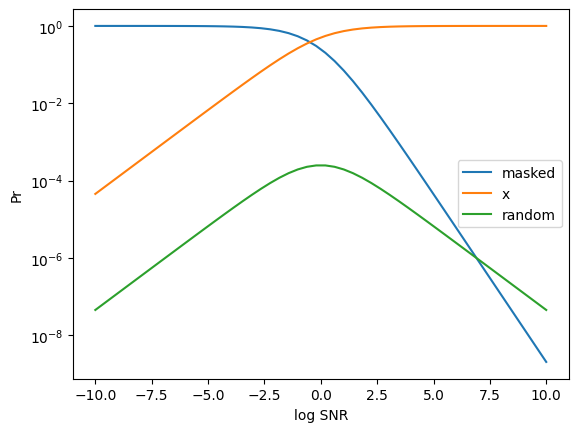

In [46]:
import matplotlib.pyplot as plt

plt.plot(log_snr, probs[:, 0], label="masked")
plt.plot(log_snr, probs[:, 1], label="x")
plt.plot(log_snr, probs[:, 2], label="random")
plt.xlabel("log SNR")
plt.ylabel("Pr")
plt.legend()

plt.yscale("log")

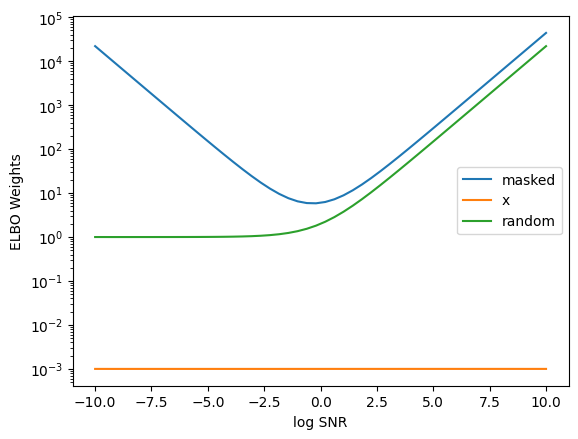

In [44]:
import matplotlib.pyplot as plt

plt.plot(log_snr, elbo_weights[0], label="masked")
plt.plot(log_snr, elbo_weights[1], label="x")
plt.plot(log_snr, elbo_weights[2], label="random")
plt.xlabel("log SNR")
plt.ylabel("ELBO Weights")
plt.legend()

plt.yscale("log")

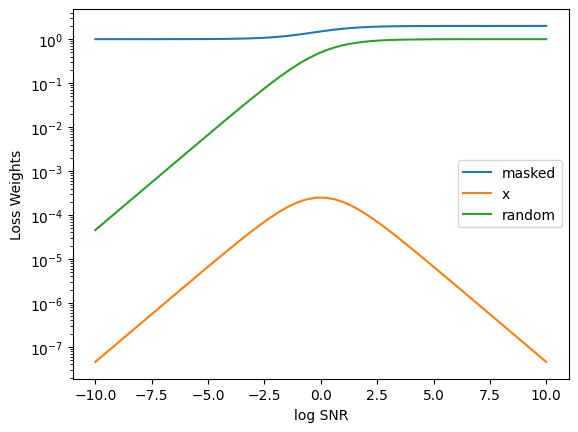

In [47]:
import matplotlib.pyplot as plt

plt.plot(log_snr, aux["loss_weights"][0], label="masked")
plt.plot(log_snr, aux["loss_weights"][1], label="x")
plt.plot(log_snr, aux["loss_weights"][2], label="random")
plt.xlabel("log SNR")
plt.ylabel("Loss Weights")
plt.legend()

plt.yscale("log")